# Helper Functions

In [39]:
def load_data(path, subject):
    # path where to save the datasets.
    bids_root = path
    subject_id = subject


    bids_path = BIDSPath(subject=subject_id,task="N170",session="N170",
                     datatype='eeg', suffix='eeg',
                     root=bids_root)

    # read the file
    raw = read_raw_bids(bids_path)
    # fix the annotations reading
    ccs_eeg_utils.read_annotations_core(bids_path,raw)

    raw.load_data()
    return raw

In [40]:
def add_channel_locations(raw):
    # tell compiler that these are no eeg channels
    raw.set_channel_types({'HEOG_left':'eog'})
    raw.set_channel_types({'HEOG_right':'eog'})
    raw.set_channel_types({'VEOG_lower':'eog'})

    raw.set_montage('standard_1020',match_case=False)

In [41]:
def filter_data(raw, low_bound, high_bound):
    # using mne filters for the eeg signal
    filtered_raw = raw.copy().filter(low_bound,high_bound, fir_design='firwin')
    return filtered_raw

In [42]:
def bad_segments(raw, subject_id):
    #find_bad_segments(raw, subject_id)
    load_bad_segments(raw, subject_id)
    
    if subject_id == '001':
        raw.info['bads'] = ['F8']

In [43]:
def find_bad_segments(raw, subject_id):
    # press a and mark bad channels by hand (holding right click)
    raw.plot(n_channels=len(raw.ch_names))
    # save bad channels
    #bad_ix = [i for i,a in enumerate(raw.annotations) if a['description']=="BAD_"]
    #raw.annotations[bad_ix].save("sub-{}_task-N170_badannotations.csv".format(subject_id))

In [44]:
def load_bad_segments(raw, subject_id):
    # load bad channels
    annotations = mne.read_annotations("sub-{}_task-N170_badannotations.csv".format(subject_id))
    raw.annotations.append(annotations.onset,annotations.duration,annotations.description)

In [45]:
def ica_filtering(raw, subject_id):
    # setup data with filter frequence 1.5Hz
    ica_raw = raw.copy()
    ica_raw.load_data().filter(l_freq=1, h_freq=None)
    ica = mne.preprocessing.ICA(method="fastica", random_state=111)
    ica.fit(raw,verbose=True)
    
    # max range = 30 - bad_channels (bad channels = 1 for Sub001)
    #ica.plot_components(range(30))
    # ica.plot_sources(raw, show_scrollbars=False)
    
    icaact = ica.get_sources(ica_raw)
    #plt.plot(icaact[5,0:20000][0].T)
    #plt.plot(ica_raw[0,0:20000][0].T)
    
    reload(mne)
    #ica.plot_properties(ica_raw,picks=[0,1],psd_args={'fmax': 35.},reject=None)
    
    # this is used to find bad components from ICA by hand
    #%matplotlib inline
    ica.plot_properties(inst=ica_raw, dB=False, topomap_args={'extrapolate': 'head', 'contours': 0},
                            psd_args={'fmin': 0, 'fmax': 50}, picks=['eeg'])
    
    eog_ind= []
    # find bad components via eog
    #eog_ind, _ = ica.find_bads_eog(raw)
    print('EOG Bad Components: ' + str(eog_ind))
    
    reconst_raw = raw.copy()
    # eog bads plus some additional found via analysing the spectrum of the components (likely muscle articats)
    expert_analysis_list = []
    if subject_id == '001':
        expert_analysis_list = [5,6,14,21]
    elif subject_id == '017':
        expert_analysis_list = [9]
    elif subject_id == '031':
        expert_analysis_list = []
        
    exclude_list = eog_ind
    for element in expert_analysis_list:
        if element not in exclude_list:
            exclude_list.append(element)
    ica.apply(reconst_raw,exclude=exclude_list)

    raw.plot()
    reconst_raw.plot()  
    ica.plot_overlay(raw,exclude=exclude_list)
    return reconst_raw

# Load Data

In [47]:
import osfclient
import mne
import mne_bids
import numpy as np
import ccs_eeg_utils
from ccs_eeg_semesterproject import (load_precomputed_badData, load_precomputed_ica)
from mne_bids import (BIDSPath,read_raw_bids)
from matplotlib import pyplot as plt
from importlib import reload  

%matplotlib qt
path = "../local/bidsN170"
temp_path = "/ses-N170/eeg/"
sub = '001'

# Preprocessing For Subjects 001, 017, 031

In [48]:
raw = load_data(path, sub)

# plot all channels (press a in that window)
# raw.plot(n_channels=len(raw.ch_names))#,scalings =40e-6)
# raw.plot_psd(area_mode='range', tmax=10.0, average=False,xscale="linear")

Reading ..\local\bidsN170\sub-001\ses-N170\eeg\sub-001_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-001\ses-N170\eeg\sub-001_ses-N170_task-N170_events.tsv.
Reading 0 ... 699391  =      0.000 ...   682.999 secs...


<ipython-input-39-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-001_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-001_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-39-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-001_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-001\\ses-N170\\eeg\\sub-001_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-001\\ses-N170\\eeg\\sub-001_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-001\**\sub-001_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-39-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-001_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-001\**\sub-001_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-39-8ec0acff4cc9>:12: RuntimeWa

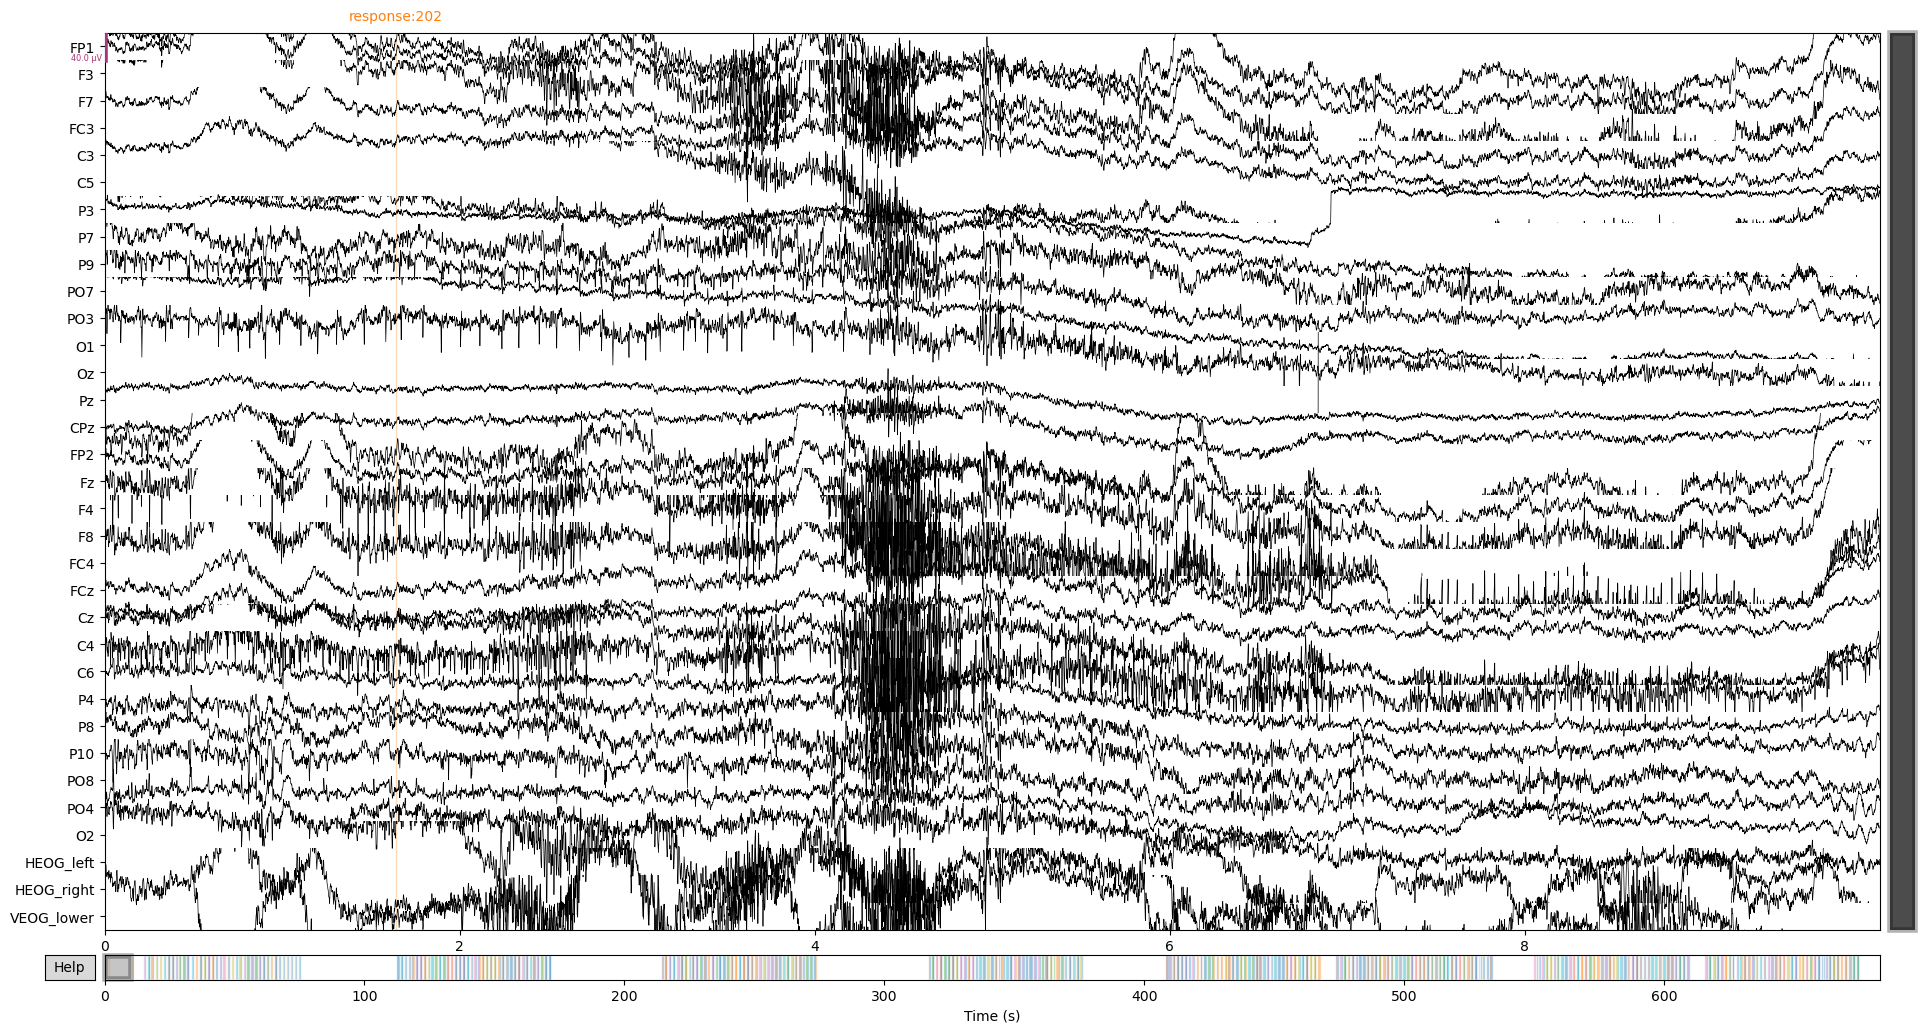

Channels marked as bad: none


In [19]:
raw.plot(n_channels=len(raw.ch_names))

In [49]:
add_channel_locations(raw)

Effective window size : 2.000 (s)


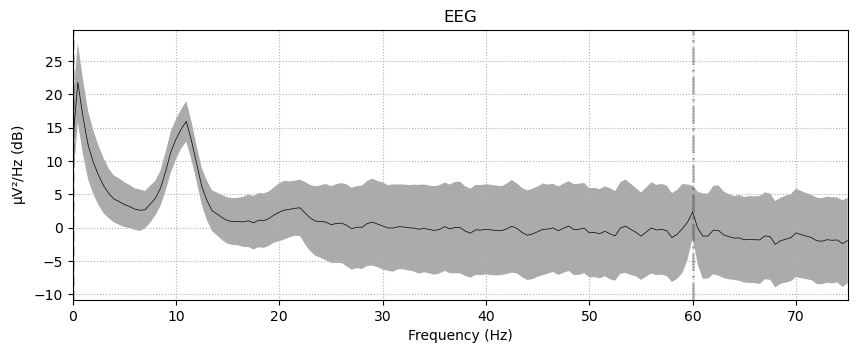

In [50]:
raw.plot_psd(fmax=75., average=True, spatial_colors=False)
# plt.savefig('./preprocessing_images/testtest')

In [51]:
raw_filtered = filter_data(raw, 0.5, 50)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)



Effective window size : 2.000 (s)


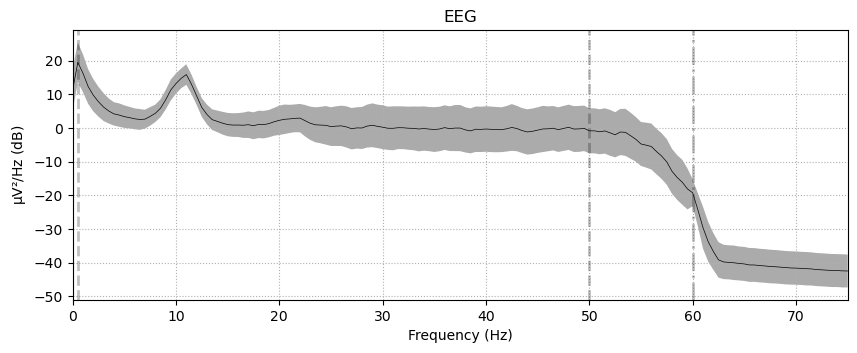

In [52]:
# as sanity check
raw_filtered.plot_psd(fmax=75., average=True, spatial_colors=False)
# plt.savefig('./preprocessing_images/testtest')

In [53]:
raw = raw_filtered

In [54]:
# To detect waves of x Hz you need at least sampling with 2*x Hz (Nyquist–Shannon sampling theorem)
# raw_resampled = raw.copy().resample(100, npad='auto')  

In [55]:
bad_segments(raw, sub)

In [56]:
raw_ica = ica_filtering(raw, sub)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3381 samples (3.302 sec)

Fitting ICA to data using 29 channels (please be patient, this may take a while)
Omitting 20361 of 699392 (2.91%) samples, retaining 679031 (97.09%) samples.
Selecting by non-zero PCA components: 29 components
Fitting ICA took 27.7s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
324 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
324 matching events found
No baseline correction applied
0 proj

C:\Users\Kay\anaconda3\lib\site-packages\mne\viz\ica.py:110: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize, facecolor=[0.95] * 3)


Not setting metadata
Not setting metadata
324 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
324 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
324 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
324 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
324 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
324 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
324 matching events found
No baseline correction applied
0 proje

In [82]:
raw_ica.interpolate_bads()

<ipython-input-82-22e9af2ea844>:1: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_ica.interpolate_bads()


<RawEEGLAB | sub-031_ses-N170_task-N170_eeg.fdt, 33 x 576512 (563.0 s), ~145.2 MB, data loaded>

In [83]:
raw = raw_ica

In [84]:
raw_rereference, _  = mne.set_eeg_reference(raw, 'average', projection=True)
raw_rereference.apply_proj()

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


<RawEEGLAB | sub-031_ses-N170_task-N170_eeg.fdt, 33 x 576512 (563.0 s), ~145.2 MB, data loaded>

In [85]:
save_path = path + "/sub-" + sub + temp_path + "sub-" + sub +"_cleaned.fif"
raw_rereference.save(save_path, overwrite=True)

Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-031\ses-N170\eeg\sub-031_cleaned.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-031\ses-N170\eeg\sub-031_cleaned.fif


<ipython-input-85-90e75c1d979a>:2: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-031\ses-N170\eeg\sub-031_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]


# Preprocessing For The Remaining Subjects

In [13]:
for s in range(1,41):
    # if we preprocessed the subject already, go on with next subject
    if s in [1,17,31]:
        continue
    if len(str(s)) > 1:
        sub = '0' + str(s)
    else:
        sub = '00' + str(s)
    raw = load_data(path, sub)
    add_channel_locations(raw)
    raw = filter_data(raw)
    
    # load preprocessing information
    annotations, bad_ch = load_precomputed_badData(bids_root=path, subject_id=sub, task="N170")
    ica, bad_components = load_precomputed_ica(bids_root=path, subject_id=sub, task="N170")
    
    ica.apply(raw, exclude=bad_components)
    
    raw_rereference, _  = mne.set_eeg_reference(raw, 'average', projection=True)
    raw_rereference.apply_proj()
    
    save_path = path + "/sub-" + sub + temp_path + "sub-" + sub +"_cleaned.fif"
    raw_rereference.save(save_path, overwrite=True)
print('DONE')

Reading ..\local\bidsN170\sub-002\ses-N170\eeg\sub-002_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-002\ses-N170\eeg\sub-002_ses-N170_task-N170_events.tsv.
Reading 0 ... 683007  =      0.000 ...   666.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-002_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-002_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-002_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-002\\ses-N170\\eeg\\sub-002_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-002\\ses-N170\\eeg\\sub-002_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-002\**\sub-002_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-002_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-002\**\sub-002_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-002\ses-N170\eeg\sub-002_ses-N170_task-N170_
Applying ICA to Raw instance


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-002\ses-N170\eeg\sub-002_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-002\ses-N170\eeg\sub-002_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-002\ses-N170\eeg\sub-002_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-002\ses-N170\eeg\sub-002_cleaned.fif
[done]
Reading ..\local\bidsN170\sub-003\ses-N170\eeg\sub-003_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-003\ses-N170\eeg\sub-003_ses-N170_task-N170_events.tsv.
Reading 0 ... 579583  =      0.000 ...   565.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-003_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-003_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-003_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-003\\ses-N170\\eeg\\sub-003_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-003\\ses-N170\\eeg\\sub-003_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-003\**\sub-003_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-003_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-003\**\sub-003_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-003\ses-N170\eeg\sub-003_ses-N170_task-N170_
Applying ICA to Raw instance


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-003\ses-N170\eeg\sub-003_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Transforming to ICA space (30 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-003\ses-N170\eeg\sub-003_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-003\ses-N170\eeg\sub-003_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-003\ses-N170\eeg\sub-003_cleaned.fif
[done]
Reading ..\local\bidsN170\sub-004\ses-N170\eeg\sub-004_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-004\ses-N170\eeg\sub-004_ses-N170_task-N170_events.tsv.
Reading 0 ... 649215  =      0.000 ...   633.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-004_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-004_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-004_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-004\\ses-N170\\eeg\\sub-004_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-004\\ses-N170\\eeg\\sub-004_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-004\**\sub-004_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-004_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-004\**\sub-004_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-004\ses-N170\eeg\sub-004_ses-N170_task-N170_
Applying ICA to Raw instance


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-004\ses-N170\eeg\sub-004_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Transforming to ICA space (30 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-004\ses-N170\eeg\sub-004_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-004\ses-N170\eeg\sub-004_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-004\ses-N170\eeg\sub-004_cleaned.fif
[done]
Reading ..\local\bidsN170\sub-005\ses-N170\eeg\sub-005_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-005\ses-N170\eeg\sub-005_ses-N170_task-N170_events.tsv.
Reading 0 ... 603135  =      0.000 ...   588.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-005_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-005_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-005_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-005\\ses-N170\\eeg\\sub-005_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-005\\ses-N170\\eeg\\sub-005_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-005\**\sub-005_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-005_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-005\**\sub-005_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-005\ses-N170\eeg\sub-005_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-005\ses-N170\eeg\sub-005_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-005\ses-N170\eeg\sub-005_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-005\ses-N170\eeg\sub-005_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-005\ses-N170\eeg\sub-005_cleaned.fif
[done]
Reading ..\local\bidsN170\sub-006\ses-N170\eeg\sub-006_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-006\ses-N170\eeg\sub-006_ses-N170_task-N170_events.tsv.
Reading 0 ... 529407  =      0.000 ...   516.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-006_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-006_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-006_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-006\\ses-N170\\eeg\\sub-006_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-006\\ses-N170\\eeg\\sub-006_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-006\**\sub-006_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-006_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-006\**\sub-006_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-006\ses-N170\eeg\sub-006_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-006\ses-N170\eeg\sub-006_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-006\ses-N170\eeg\sub-006_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-006\ses-N170\eeg\sub-006_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-006\ses-N170\eeg\sub-006_cleaned.fif
[done]
Reading ..\local\bidsN170\sub-007\ses-N170\eeg\sub-007_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-007\ses-N170\eeg\sub-007_ses-N170_task-N170_events.tsv.
Reading 0 ... 589823  =      0.000 ...   575.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-007_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-007_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-007_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-007\\ses-N170\\eeg\\sub-007_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-007\\ses-N170\\eeg\\sub-007_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-007\**\sub-007_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-007_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-007\**\sub-007_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-007\ses-N170\eeg\sub-007_ses-N170_task-N170_


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-007\ses-N170\eeg\sub-007_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-007\ses-N170\eeg\sub-007_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-007\ses-N170\eeg\sub-007_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-007\ses-N170\eeg\sub-007_cleaned.fif
[done]
Reading ..\local\bidsN170\sub-008\ses-N170\eeg\sub-008_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-008\ses-N170\eeg\sub-008_ses-N170_task-N170_events.tsv.
Reading 0 ... 804863  =      0.000 ...   785.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-008_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-008_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-008_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-008\\ses-N170\\eeg\\sub-008_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-008\\ses-N170\\eeg\\sub-008_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-008\**\sub-008_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-008_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-008\**\sub-008_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-008\ses-N170\eeg\sub-008_ses-N170_task-N170_
Applying ICA to Raw instance


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-008\ses-N170\eeg\sub-008_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-008\ses-N170\eeg\sub-008_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-008\ses-N170\eeg\sub-008_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-008\ses-N170\eeg\sub-008_cleaned.fif
[done]
Reading ..\local\bidsN170\sub-009\ses-N170\eeg\sub-009_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-009\ses-N170\eeg\sub-009_ses-N170_task-N170_events.tsv.
Reading 0 ... 559103  =      0.000 ...   545.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-009_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-009_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-009_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-009\\ses-N170\\eeg\\sub-009_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-009\\ses-N170\\eeg\\sub-009_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-009\**\sub-009_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-009_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-009\**\sub-009_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-009\ses-N170\eeg\sub-009_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-009\ses-N170\eeg\sub-009_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-009\ses-N170\eeg\sub-009_cleaned.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-009\ses-N170\eeg\sub-009_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-009\ses-N170\eeg\sub-009_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]
Reading ..\local\bidsN170\sub-010\ses-N170\eeg\sub-010_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-010\ses-N170\eeg\sub-010_ses-N170_task-N170_events.tsv.
Reading 0 ... 556031  =      0.000 ...   542.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-010_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-010_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-010_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-010\\ses-N170\\eeg\\sub-010_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-010\\ses-N170\\eeg\\sub-010_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-010\**\sub-010_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-010_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-010\**\sub-010_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-010\ses-N170\eeg\sub-010_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-010\ses-N170\eeg\sub-010_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-010\ses-N170\eeg\sub-010_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-010\ses-N170\eeg\sub-010_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-010\ses-N170\eeg\sub-010_cleaned.fif
[done]
Reading ..\local\bidsN170\sub-011\ses-N170\eeg\sub-011_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-011\ses-N170\eeg\sub-011_ses-N170_task-N170_events.tsv.
Reading 0 ... 582655  =      0.000 ...   568.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-011_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-011_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-011_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-011\\ses-N170\\eeg\\sub-011_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-011\\ses-N170\\eeg\\sub-011_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-011\**\sub-011_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-011_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-011\**\sub-011_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-011\ses-N170\eeg\sub-011_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-011\ses-N170\eeg\sub-011_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-011\ses-N170\eeg\sub-011_cleaned.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-011\ses-N170\eeg\sub-011_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-011\ses-N170\eeg\sub-011_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]
Reading ..\local\bidsN170\sub-012\ses-N170\eeg\sub-012_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-012\ses-N170\eeg\sub-012_ses-N170_task-N170_events.tsv.
Reading 0 ... 537599  =      0.000 ...   524.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-012_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-012_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-012_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-012\\ses-N170\\eeg\\sub-012_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-012\\ses-N170\\eeg\\sub-012_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-012\**\sub-012_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-012_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-012\**\sub-012_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-012\ses-N170\eeg\sub-012_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-012\ses-N170\eeg\sub-012_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-012\ses-N170\eeg\sub-012_cleaned.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-012\ses-N170\eeg\sub-012_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-012\ses-N170\eeg\sub-012_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]
Reading ..\local\bidsN170\sub-013\ses-N170\eeg\sub-013_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-013\ses-N170\eeg\sub-013_ses-N170_task-N170_events.tsv.
Reading 0 ... 601087  =      0.000 ...   586.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-013_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-013_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-013_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-013\\ses-N170\\eeg\\sub-013_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-013\\ses-N170\\eeg\\sub-013_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-013\**\sub-013_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-013_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-013\**\sub-013_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-013\ses-N170\eeg\sub-013_ses-N170_task-N170_
Applying ICA to Raw instance


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-013\ses-N170\eeg\sub-013_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-013\ses-N170\eeg\sub-013_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-013\ses-N170\eeg\sub-013_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-013\ses-N170\eeg\sub-013_cleaned.fif
[done]
Reading ..\local\bidsN170\sub-014\ses-N170\eeg\sub-014_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-014\ses-N170\eeg\sub-014_ses-N170_task-N170_events.tsv.
Reading 0 ... 566271  =      0.000 ...   552.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-014_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-014_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-014_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-014\\ses-N170\\eeg\\sub-014_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-014\\ses-N170\\eeg\\sub-014_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-014\**\sub-014_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-014_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-014\**\sub-014_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-014\ses-N170\eeg\sub-014_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-014\ses-N170\eeg\sub-014_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-014\ses-N170\eeg\sub-014_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-014\ses-N170\eeg\sub-014_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-014\ses-N170\eeg\sub-014_cleaned.fif
[done]
Reading ..\local\bidsN170\sub-015\ses-N170\eeg\sub-015_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-015\ses-N170\eeg\sub-015_ses-N170_task-N170_events.tsv.
Reading 0 ... 589823  =      0.000 ...   575.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-015_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-015_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-015_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-015\\ses-N170\\eeg\\sub-015_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-015\\ses-N170\\eeg\\sub-015_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-015\**\sub-015_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-015_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-015\**\sub-015_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-015\ses-N170\eeg\sub-015_ses-N170_task-N170_
Applying ICA to Raw instance


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-015\ses-N170\eeg\sub-015_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Transforming to ICA space (30 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-015\ses-N170\eeg\sub-015_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-015\ses-N170\eeg\sub-015_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-015\ses-N170\eeg\sub-015_cleaned.fif
[done]
Reading ..\local\bidsN170\sub-016\ses-N170\eeg\sub-016_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-016\ses-N170\eeg\sub-016_ses-N170_task-N170_events.tsv.
Reading 0 ... 646143  =      0.000 ...   630.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-016_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-016_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-016_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-016\\ses-N170\\eeg\\sub-016_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-016\\ses-N170\\eeg\\sub-016_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-016\**\sub-016_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-016_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-016\**\sub-016_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-016\ses-N170\eeg\sub-016_ses-N170_task-N170_
Applying ICA to Raw instance


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-016\ses-N170\eeg\sub-016_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Transforming to ICA space (30 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-016\ses-N170\eeg\sub-016_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-016\ses-N170\eeg\sub-016_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-016\ses-N170\eeg\sub-016_cleaned.fif
[done]
Reading ..\local\bidsN170\sub-018\ses-N170\eeg\sub-018_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-018\ses-N170\eeg\sub-018_ses-N170_task-N170_events.tsv.
Reading 0 ... 622591  =      0.000 ...   607.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-018_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-018_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-018_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-018\\ses-N170\\eeg\\sub-018_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-018\\ses-N170\\eeg\\sub-018_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-018\**\sub-018_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-018_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-018\**\sub-018_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-018\ses-N170\eeg\sub-018_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-018\ses-N170\eeg\sub-018_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-018\ses-N170\eeg\sub-018_cleaned.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-018\ses-N170\eeg\sub-018_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-018\ses-N170\eeg\sub-018_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]
Reading ..\local\bidsN170\sub-019\ses-N170\eeg\sub-019_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-019\ses-N170\eeg\sub-019_ses-N170_task-N170_events.tsv.
Reading 0 ... 535551  =      0.000 ...   522.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-019_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-019_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-019_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-019\\ses-N170\\eeg\\sub-019_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-019\\ses-N170\\eeg\\sub-019_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-019\**\sub-019_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-019_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-019\**\sub-019_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-019\ses-N170\eeg\sub-019_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-019\ses-N170\eeg\sub-019_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-019\ses-N170\eeg\sub-019_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-019\ses-N170\eeg\sub-019_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-019\ses-N170\eeg\sub-019_cleaned.fif
[done]
Reading ..\local\bidsN170\sub-020\ses-N170\eeg\sub-020_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-020\ses-N170\eeg\sub-020_ses-N170_task-N170_events.tsv.
Reading 0 ... 599039  =      0.000 ...   584.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-020_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-020_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-020_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-020\\ses-N170\\eeg\\sub-020_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-020\\ses-N170\\eeg\\sub-020_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-020\**\sub-020_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-020_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-020\**\sub-020_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-020\ses-N170\eeg\sub-020_ses-N170_task-N170_
Applying ICA to Raw instance


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-020\ses-N170\eeg\sub-020_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-020\ses-N170\eeg\sub-020_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-020\ses-N170\eeg\sub-020_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-020\ses-N170\eeg\sub-020_cleaned.fif
[done]
Reading ..\local\bidsN170\sub-021\ses-N170\eeg\sub-021_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-021\ses-N170\eeg\sub-021_ses-N170_task-N170_events.tsv.
Reading 0 ... 570367  =      0.000 ...   556.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-021_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-021_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-021_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-021\\ses-N170\\eeg\\sub-021_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-021\\ses-N170\\eeg\\sub-021_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-021\**\sub-021_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-021_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-021\**\sub-021_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-021\ses-N170\eeg\sub-021_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-021\ses-N170\eeg\sub-021_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-021\ses-N170\eeg\sub-021_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-021\ses-N170\eeg\sub-021_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-021\ses-N170\eeg\sub-021_cleaned.fif
[done]
Reading ..\local\bidsN170\sub-022\ses-N170\eeg\sub-022_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-022\ses-N170\eeg\sub-022_ses-N170_task-N170_events.tsv.
Reading 0 ... 591871  =      0.000 ...   577.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-022_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-022_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-022_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-022\\ses-N170\\eeg\\sub-022_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-022\\ses-N170\\eeg\\sub-022_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-022\**\sub-022_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-022_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-022\**\sub-022_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-022\ses-N170\eeg\sub-022_ses-N170_task-N170_
Applying ICA to Raw instance


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-022\ses-N170\eeg\sub-022_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Transforming to ICA space (30 components)
    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-022\ses-N170\eeg\sub-022_cleaned.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-022\ses-N170\eeg\sub-022_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-022\ses-N170\eeg\sub-022_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]
Reading ..\local\bidsN170\sub-023\ses-N170\eeg\sub-023_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-023\ses-N170\eeg\sub-023_ses-N170_task-N170_events.tsv.
Reading 0 ... 564223  =      0.000 ...   550.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-023_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-023_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-023_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-023\\ses-N170\\eeg\\sub-023_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-023\\ses-N170\\eeg\\sub-023_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-023\**\sub-023_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-023_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-023\**\sub-023_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-023\ses-N170\eeg\sub-023_ses-N170_task-N170_
Applying ICA to Raw instance


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-023\ses-N170\eeg\sub-023_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-023\ses-N170\eeg\sub-023_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-023\ses-N170\eeg\sub-023_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-023\ses-N170\eeg\sub-023_cleaned.fif
[done]
Reading ..\local\bidsN170\sub-024\ses-N170\eeg\sub-024_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-024\ses-N170\eeg\sub-024_ses-N170_task-N170_events.tsv.
Reading 0 ... 580607  =      0.000 ...   566.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-024_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-024_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-024_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-024\\ses-N170\\eeg\\sub-024_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-024\\ses-N170\\eeg\\sub-024_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-024\**\sub-024_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-024_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-024\**\sub-024_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-024\ses-N170\eeg\sub-024_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-024\ses-N170\eeg\sub-024_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-024\ses-N170\eeg\sub-024_cleaned.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-024\ses-N170\eeg\sub-024_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-024\ses-N170\eeg\sub-024_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]
Reading ..\local\bidsN170\sub-025\ses-N170\eeg\sub-025_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-025\ses-N170\eeg\sub-025_ses-N170_task-N170_events.tsv.
Reading 0 ... 591871  =      0.000 ...   577.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-025_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-025_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-025_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-025\\ses-N170\\eeg\\sub-025_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-025\\ses-N170\\eeg\\sub-025_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-025\**\sub-025_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-025_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-025\**\sub-025_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-025\ses-N170\eeg\sub-025_ses-N170_task-N170_
Applying ICA to Raw instance


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-025\ses-N170\eeg\sub-025_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-025\ses-N170\eeg\sub-025_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-025\ses-N170\eeg\sub-025_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-025\ses-N170\eeg\sub-025_cleaned.fif
[done]
Reading ..\local\bidsN170\sub-026\ses-N170\eeg\sub-026_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-026\ses-N170\eeg\sub-026_ses-N170_task-N170_events.tsv.
Reading 0 ... 568319  =      0.000 ...   554.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-026_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-026_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-026_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-026\\ses-N170\\eeg\\sub-026_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-026\\ses-N170\\eeg\\sub-026_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-026\**\sub-026_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-026_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-026\**\sub-026_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-026\ses-N170\eeg\sub-026_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-026\ses-N170\eeg\sub-026_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-026\ses-N170\eeg\sub-026_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-026\ses-N170\eeg\sub-026_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-026\ses-N170\eeg\sub-026_cleaned.fif
[done]
Reading ..\local\bidsN170\sub-027\ses-N170\eeg\sub-027_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-027\ses-N170\eeg\sub-027_ses-N170_task-N170_events.tsv.
Reading 0 ... 578559  =      0.000 ...   564.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-027_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-027_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-027_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-027\\ses-N170\\eeg\\sub-027_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-027\\ses-N170\\eeg\\sub-027_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-027\**\sub-027_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-027_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-027\**\sub-027_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-027\ses-N170\eeg\sub-027_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-027\ses-N170\eeg\sub-027_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-027\ses-N170\eeg\sub-027_cleaned.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-027\ses-N170\eeg\sub-027_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-027\ses-N170\eeg\sub-027_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]
Reading ..\local\bidsN170\sub-028\ses-N170\eeg\sub-028_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-028\ses-N170\eeg\sub-028_ses-N170_task-N170_events.tsv.
Reading 0 ... 572415  =      0.000 ...   558.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-028_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-028_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-028_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-028\\ses-N170\\eeg\\sub-028_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-028\\ses-N170\\eeg\\sub-028_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-028\**\sub-028_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-028_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-028\**\sub-028_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-028\ses-N170\eeg\sub-028_ses-N170_task-N170_
Applying ICA to Raw instance


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-028\ses-N170\eeg\sub-028_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Transforming to ICA space (30 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-028\ses-N170\eeg\sub-028_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-028\ses-N170\eeg\sub-028_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-028\ses-N170\eeg\sub-028_cleaned.fif
[done]
Reading ..\local\bidsN170\sub-029\ses-N170\eeg\sub-029_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-029\ses-N170\eeg\sub-029_ses-N170_task-N170_events.tsv.
Reading 0 ... 604159  =      0.000 ...   589.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-029_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-029_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-029_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-029\\ses-N170\\eeg\\sub-029_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-029\\ses-N170\\eeg\\sub-029_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-029\**\sub-029_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-029_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-029\**\sub-029_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-029\ses-N170\eeg\sub-029_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-029\ses-N170\eeg\sub-029_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-029\ses-N170\eeg\sub-029_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-029\ses-N170\eeg\sub-029_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-029\ses-N170\eeg\sub-029_cleaned.fif
[done]
Reading ..\local\bidsN170\sub-030\ses-N170\eeg\sub-030_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-030\ses-N170\eeg\sub-030_ses-N170_task-N170_events.tsv.
Reading 0 ... 574463  =      0.000 ...   560.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-030_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-030_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-030_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-030\\ses-N170\\eeg\\sub-030_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-030\\ses-N170\\eeg\\sub-030_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-030\**\sub-030_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-030_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-030\**\sub-030_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-030\ses-N170\eeg\sub-030_ses-N170_task-N170_
Applying ICA to Raw instance


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-030\ses-N170\eeg\sub-030_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Transforming to ICA space (30 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-030\ses-N170\eeg\sub-030_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-030\ses-N170\eeg\sub-030_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-030\ses-N170\eeg\sub-030_cleaned.fif
[done]
Reading ..\local\bidsN170\sub-032\ses-N170\eeg\sub-032_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-032\ses-N170\eeg\sub-032_ses-N170_task-N170_events.tsv.
Reading 0 ... 578559  =      0.000 ...   564.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-032_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-032_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-032_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-032\\ses-N170\\eeg\\sub-032_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-032\\ses-N170\\eeg\\sub-032_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-032\**\sub-032_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-032_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-032\**\sub-032_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-032\ses-N170\eeg\sub-032_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-032\ses-N170\eeg\sub-032_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-032\ses-N170\eeg\sub-032_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-032\ses-N170\eeg\sub-032_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-032\ses-N170\eeg\sub-032_cleaned.fif
[done]
Reading ..\local\bidsN170\sub-033\ses-N170\eeg\sub-033_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-033\ses-N170\eeg\sub-033_ses-N170_task-N170_events.tsv.
Reading 0 ... 570367  =      0.000 ...   556.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-033_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-033_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-033_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-033\\ses-N170\\eeg\\sub-033_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-033\\ses-N170\\eeg\\sub-033_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-033\**\sub-033_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-033_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-033\**\sub-033_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-033\ses-N170\eeg\sub-033_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-033\ses-N170\eeg\sub-033_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-033\ses-N170\eeg\sub-033_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-033\ses-N170\eeg\sub-033_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-033\ses-N170\eeg\sub-033_cleaned.fif
[done]
Reading ..\local\bidsN170\sub-034\ses-N170\eeg\sub-034_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-034\ses-N170\eeg\sub-034_ses-N170_task-N170_events.tsv.
Reading 0 ... 547839  =      0.000 ...   534.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-034_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-034_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-034_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-034\\ses-N170\\eeg\\sub-034_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-034\\ses-N170\\eeg\\sub-034_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-034\**\sub-034_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-034_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-034\**\sub-034_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-034\ses-N170\eeg\sub-034_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-034\ses-N170\eeg\sub-034_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-034\ses-N170\eeg\sub-034_cleaned.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-034\ses-N170\eeg\sub-034_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-034\ses-N170\eeg\sub-034_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]
Reading ..\local\bidsN170\sub-035\ses-N170\eeg\sub-035_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-035\ses-N170\eeg\sub-035_ses-N170_task-N170_events.tsv.
Reading 0 ... 620543  =      0.000 ...   605.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-035_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-035_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-035_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-035\\ses-N170\\eeg\\sub-035_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-035\\ses-N170\\eeg\\sub-035_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-035\**\sub-035_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-035_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-035\**\sub-035_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-035\ses-N170\eeg\sub-035_ses-N170_task-N170_
Applying ICA to Raw instance


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-035\ses-N170\eeg\sub-035_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-035\ses-N170\eeg\sub-035_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-035\ses-N170\eeg\sub-035_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-035\ses-N170\eeg\sub-035_cleaned.fif
[done]
Reading ..\local\bidsN170\sub-036\ses-N170\eeg\sub-036_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-036\ses-N170\eeg\sub-036_ses-N170_task-N170_events.tsv.
Reading 0 ... 542719  =      0.000 ...   529.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-036_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-036_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-036_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-036\\ses-N170\\eeg\\sub-036_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-036\\ses-N170\\eeg\\sub-036_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-036\**\sub-036_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-036_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-036\**\sub-036_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-036\ses-N170\eeg\sub-036_ses-N170_task-N170_
Applying ICA to Raw instance


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-036\ses-N170\eeg\sub-036_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-036\ses-N170\eeg\sub-036_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-036\ses-N170\eeg\sub-036_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-036\ses-N170\eeg\sub-036_cleaned.fif
[done]
Reading ..\local\bidsN170\sub-037\ses-N170\eeg\sub-037_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-037\ses-N170\eeg\sub-037_ses-N170_task-N170_events.tsv.
Reading 0 ... 595967  =      0.000 ...   581.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-037_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-037_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-037_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-037\\ses-N170\\eeg\\sub-037_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-037\\ses-N170\\eeg\\sub-037_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-037\**\sub-037_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-037_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-037\**\sub-037_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-037\ses-N170\eeg\sub-037_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-037\ses-N170\eeg\sub-037_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-037\ses-N170\eeg\sub-037_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-037\ses-N170\eeg\sub-037_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-037\ses-N170\eeg\sub-037_cleaned.fif
[done]
Reading ..\local\bidsN170\sub-038\ses-N170\eeg\sub-038_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-038\ses-N170\eeg\sub-038_ses-N170_task-N170_events.tsv.
Reading 0 ... 852991  =      0.000 ...   832.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-038_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-038_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-038_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-038\\ses-N170\\eeg\\sub-038_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-038\\ses-N170\\eeg\\sub-038_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-038\**\sub-038_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-038_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-038\**\sub-038_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-038\ses-N170\eeg\sub-038_ses-N170_task-N170_


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-038\ses-N170\eeg\sub-038_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-038\ses-N170\eeg\sub-038_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-038\ses-N170\eeg\sub-038_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-038\ses-N170\eeg\sub-038_cleaned.fif
[done]
Reading ..\local\bidsN170\sub-039\ses-N170\eeg\sub-039_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-039\ses-N170\eeg\sub-039_ses-N170_task-N170_events.tsv.
Reading 0 ... 653311  =      0.000 ...   637.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-039_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-039_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-039_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-039\\ses-N170\\eeg\\sub-039_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-039\\ses-N170\\eeg\\sub-039_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-039\**\sub-039_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-039_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-039\**\sub-039_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-039\ses-N170\eeg\sub-039_ses-N170_task-N170_


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-039\ses-N170\eeg\sub-039_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-039\ses-N170\eeg\sub-039_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-039\ses-N170\eeg\sub-039_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-039\ses-N170\eeg\sub-039_cleaned.fif
[done]
Reading ..\local\bidsN170\sub-040\ses-N170\eeg\sub-040_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-040\ses-N170\eeg\sub-040_ses-N170_task-N170_events.tsv.
Reading 0 ... 700415  =      0.000 ...   683.999 secs...


<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-040_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-040_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-040_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-040\\ses-N170\\eeg\\sub-040_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-040\\ses-N170\\eeg\\sub-040_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-040\**\sub-040_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-040_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-040\**\sub-040_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-2-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-040\ses-N170\eeg\sub-040_ses-N170_task-N170_


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-040\ses-N170\eeg\sub-040_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Overwriting existing file.
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-040\ses-N170\eeg\sub-040_cleaned.fif


<ipython-input-13-5dd91fd5c82e>:23: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-040\ses-N170\eeg\sub-040_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-040\ses-N170\eeg\sub-040_cleaned.fif
[done]
DONE


## save preprocessing without setting channel positions to avoide a strange bug in decoding

In [12]:
for s in range(1,41):
    # if we preprocessed the subject already, go on with next subject
    if s in [1,17,31]:
        continue
    if len(str(s)) > 1:
        sub = '0' + str(s)
    else:
        sub = '00' + str(s)
    raw = load_data(path, sub)
    raw = filter_data(raw)
    
    # load preprocessing information
    annotations, bad_ch = load_precomputed_badData(bids_root=path, subject_id=sub, task="N170")
    ica, bad_components = load_precomputed_ica(bids_root=path, subject_id=sub, task="N170")
    
    ica.apply(raw, exclude=bad_components)
    
    raw_rereference, _  = mne.set_eeg_reference(raw, 'average', projection=True)
    raw_rereference.apply_proj()
    
    save_path = path + "/sub-" + sub + temp_path + "sub-" + sub +"_cleaned_no_channel_positions.fif"
    raw_rereference.save(save_path, overwrite=True)
print('DONE')

Reading ..\local\bidsN170\sub-002\ses-N170\eeg\sub-002_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-002\ses-N170\eeg\sub-002_ses-N170_task-N170_events.tsv.
Reading 0 ... 683007  =      0.000 ...   666.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-002_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-002_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-002_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-002\\ses-N170\\eeg\\sub-002_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-002\\ses-N170\\eeg\\sub-002_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-002\**\sub-002_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-002_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-002\**\sub-002_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-002\ses-N170\eeg\sub-002_ses-N170_task-N170_
Applying ICA to Raw instance


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-002\ses-N170\eeg\sub-002_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-002\ses-N170\eeg\sub-002_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-002\ses-N170\eeg\sub-002_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-002\ses-N170\eeg\sub-002_cleaned_no_channel_positions.fif
[done]
Reading ..\local\bidsN170\sub-003\ses-N170\eeg\sub-003_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-003\ses-N170\eeg\sub-003_ses-N170_task-N170_events.tsv.
Reading 0 ... 579583  =      0.000 ...   565.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-003_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-003_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-003_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-003\\ses-N170\\eeg\\sub-003_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-003\\ses-N170\\eeg\\sub-003_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-003\**\sub-003_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-003_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-003\**\sub-003_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-003\ses-N170\eeg\sub-003_ses-N170_task-N170_
Applying ICA to Raw instance


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-003\ses-N170\eeg\sub-003_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Transforming to ICA space (30 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-003\ses-N170\eeg\sub-003_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-003\ses-N170\eeg\sub-003_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-003\ses-N170\eeg\sub-003_cleaned_no_channel_positions.fif
[done]
Reading ..\local\bidsN170\sub-004\ses-N170\eeg\sub-004_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-004\ses-N170\eeg\sub-004_ses-N170_task-N170_events.tsv.
Reading 0 ... 649215  =      0.000 ...   633.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-004_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-004_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-004_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-004\\ses-N170\\eeg\\sub-004_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-004\\ses-N170\\eeg\\sub-004_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-004\**\sub-004_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-004_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-004\**\sub-004_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-004\ses-N170\eeg\sub-004_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-004\ses-N170\eeg\sub-004_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-004\ses-N170\eeg\sub-004_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-004\ses-N170\eeg\sub-004_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-004\ses-N170\eeg\sub-004_cleaned_no_channel_positions.fif
[done]
Reading ..\local\bidsN170\sub-005\ses-N170\eeg\sub-005_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-005\ses-N170\eeg\sub-005_ses-N170_task-N170_events.tsv.
Reading 0 ... 603135  =      0.000 ...   588.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-005_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-005_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-005_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-005\\ses-N170\\eeg\\sub-005_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-005\\ses-N170\\eeg\\sub-005_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-005\**\sub-005_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-005_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-005\**\sub-005_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-005\ses-N170\eeg\sub-005_ses-N170_task-N170_
Applying ICA to Raw instance


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-005\ses-N170\eeg\sub-005_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Transforming to ICA space (30 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-005\ses-N170\eeg\sub-005_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-005\ses-N170\eeg\sub-005_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-005\ses-N170\eeg\sub-005_cleaned_no_channel_positions.fif
[done]
Reading ..\local\bidsN170\sub-006\ses-N170\eeg\sub-006_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-006\ses-N170\eeg\sub-006_ses-N170_task-N170_events.tsv.
Reading 0 ... 529407  =      0.000 ...   516.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-006_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-006_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-006_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-006\\ses-N170\\eeg\\sub-006_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-006\\ses-N170\\eeg\\sub-006_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-006\**\sub-006_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-006_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-006\**\sub-006_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-006\ses-N170\eeg\sub-006_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-006\ses-N170\eeg\sub-006_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-006\ses-N170\eeg\sub-006_cleaned_no_channel_positions.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-006\ses-N170\eeg\sub-006_cleaned_no_channel_positions.fif
[done]


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-006\ses-N170\eeg\sub-006_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Reading ..\local\bidsN170\sub-007\ses-N170\eeg\sub-007_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-007\ses-N170\eeg\sub-007_ses-N170_task-N170_events.tsv.
Reading 0 ... 589823  =      0.000 ...   575.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-007_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-007_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-007_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-007\\ses-N170\\eeg\\sub-007_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-007\\ses-N170\\eeg\\sub-007_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-007\**\sub-007_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-007_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-007\**\sub-007_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-007\ses-N170\eeg\sub-007_ses-N170_task-N170_
Applying ICA to Raw instance


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-007\ses-N170\eeg\sub-007_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Transforming to ICA space (30 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-007\ses-N170\eeg\sub-007_cleaned_no_channel_positions.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-007\ses-N170\eeg\sub-007_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-007\ses-N170\eeg\sub-007_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]
Reading ..\local\bidsN170\sub-008\ses-N170\eeg\sub-008_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-008\ses-N170\eeg\sub-008_ses-N170_task-N170_events.tsv.
Reading 0 ... 804863  =      0.000 ...   785.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-008_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-008_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-008_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-008\\ses-N170\\eeg\\sub-008_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-008\\ses-N170\\eeg\\sub-008_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-008\**\sub-008_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-008_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-008\**\sub-008_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-008\ses-N170\eeg\sub-008_ses-N170_task-N170_
Applying ICA to Raw instance


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-008\ses-N170\eeg\sub-008_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-008\ses-N170\eeg\sub-008_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-008\ses-N170\eeg\sub-008_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-008\ses-N170\eeg\sub-008_cleaned_no_channel_positions.fif
[done]
Reading ..\local\bidsN170\sub-009\ses-N170\eeg\sub-009_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-009\ses-N170\eeg\sub-009_ses-N170_task-N170_events.tsv.
Reading 0 ... 559103  =      0.000 ...   545.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-009_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-009_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-009_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-009\\ses-N170\\eeg\\sub-009_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-009\\ses-N170\\eeg\\sub-009_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-009\**\sub-009_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-009_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-009\**\sub-009_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-009\ses-N170\eeg\sub-009_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-009\ses-N170\eeg\sub-009_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-009\ses-N170\eeg\sub-009_cleaned_no_channel_positions.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-009\ses-N170\eeg\sub-009_cleaned_no_channel_positions.fif
[done]


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-009\ses-N170\eeg\sub-009_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Reading ..\local\bidsN170\sub-010\ses-N170\eeg\sub-010_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-010\ses-N170\eeg\sub-010_ses-N170_task-N170_events.tsv.
Reading 0 ... 556031  =      0.000 ...   542.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-010_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-010_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-010_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-010\\ses-N170\\eeg\\sub-010_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-010\\ses-N170\\eeg\\sub-010_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-010\**\sub-010_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-010_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-010\**\sub-010_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-010\ses-N170\eeg\sub-010_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 3 ICA components


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-010\ses-N170\eeg\sub-010_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-010\ses-N170\eeg\sub-010_cleaned_no_channel_positions.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-010\ses-N170\eeg\sub-010_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-010\ses-N170\eeg\sub-010_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]
Reading ..\local\bidsN170\sub-011\ses-N170\eeg\sub-011_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-011\ses-N170\eeg\sub-011_ses-N170_task-N170_events.tsv.
Reading 0 ... 582655  =      0.000 ...   568.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-011_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-011_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-011_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-011\\ses-N170\\eeg\\sub-011_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-011\\ses-N170\\eeg\\sub-011_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-011\**\sub-011_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-011_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-011\**\sub-011_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-011\ses-N170\eeg\sub-011_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-011\ses-N170\eeg\sub-011_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-011\ses-N170\eeg\sub-011_cleaned_no_channel_positions.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-011\ses-N170\eeg\sub-011_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-011\ses-N170\eeg\sub-011_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]
Reading ..\local\bidsN170\sub-012\ses-N170\eeg\sub-012_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-012\ses-N170\eeg\sub-012_ses-N170_task-N170_events.tsv.
Reading 0 ... 537599  =      0.000 ...   524.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-012_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-012_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-012_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-012\\ses-N170\\eeg\\sub-012_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-012\\ses-N170\\eeg\\sub-012_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-012\**\sub-012_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-012_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-012\**\sub-012_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-012\ses-N170\eeg\sub-012_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-012\ses-N170\eeg\sub-012_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-012\ses-N170\eeg\sub-012_cleaned_no_channel_positions.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-012\ses-N170\eeg\sub-012_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-012\ses-N170\eeg\sub-012_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]
Reading ..\local\bidsN170\sub-013\ses-N170\eeg\sub-013_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-013\ses-N170\eeg\sub-013_ses-N170_task-N170_events.tsv.
Reading 0 ... 601087  =      0.000 ...   586.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-013_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-013_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-013_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-013\\ses-N170\\eeg\\sub-013_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-013\\ses-N170\\eeg\\sub-013_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-013\**\sub-013_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-013_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-013\**\sub-013_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-013\ses-N170\eeg\sub-013_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-013\ses-N170\eeg\sub-013_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-013\ses-N170\eeg\sub-013_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-013\ses-N170\eeg\sub-013_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-013\ses-N170\eeg\sub-013_cleaned_no_channel_positions.fif
[done]
Reading ..\local\bidsN170\sub-014\ses-N170\eeg\sub-014_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-014\ses-N170\eeg\sub-014_ses-N170_task-N170_events.tsv.
Reading 0 ... 566271  =      0.000 ...   552.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-014_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-014_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-014_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-014\\ses-N170\\eeg\\sub-014_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-014\\ses-N170\\eeg\\sub-014_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-014\**\sub-014_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-014_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-014\**\sub-014_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-014\ses-N170\eeg\sub-014_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-014\ses-N170\eeg\sub-014_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-014\ses-N170\eeg\sub-014_cleaned_no_channel_positions.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-014\ses-N170\eeg\sub-014_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-014\ses-N170\eeg\sub-014_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]
Reading ..\local\bidsN170\sub-015\ses-N170\eeg\sub-015_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-015\ses-N170\eeg\sub-015_ses-N170_task-N170_events.tsv.
Reading 0 ... 589823  =      0.000 ...   575.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-015_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-015_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-015_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-015\\ses-N170\\eeg\\sub-015_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-015\\ses-N170\\eeg\\sub-015_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-015\**\sub-015_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-015_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-015\**\sub-015_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-015\ses-N170\eeg\sub-015_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 5 ICA components


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-015\ses-N170\eeg\sub-015_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-015\ses-N170\eeg\sub-015_cleaned_no_channel_positions.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-015\ses-N170\eeg\sub-015_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-015\ses-N170\eeg\sub-015_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]
Reading ..\local\bidsN170\sub-016\ses-N170\eeg\sub-016_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-016\ses-N170\eeg\sub-016_ses-N170_task-N170_events.tsv.
Reading 0 ... 646143  =      0.000 ...   630.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-016_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-016_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-016_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-016\\ses-N170\\eeg\\sub-016_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-016\\ses-N170\\eeg\\sub-016_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-016\**\sub-016_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-016_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-016\**\sub-016_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-016\ses-N170\eeg\sub-016_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-016\ses-N170\eeg\sub-016_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-016\ses-N170\eeg\sub-016_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-016\ses-N170\eeg\sub-016_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-016\ses-N170\eeg\sub-016_cleaned_no_channel_positions.fif
[done]
Reading ..\local\bidsN170\sub-018\ses-N170\eeg\sub-018_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-018\ses-N170\eeg\sub-018_ses-N170_task-N170_events.tsv.
Reading 0 ... 622591  =      0.000 ...   607.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-018_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-018_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-018_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-018\\ses-N170\\eeg\\sub-018_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-018\\ses-N170\\eeg\\sub-018_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-018\**\sub-018_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-018_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-018\**\sub-018_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-018\ses-N170\eeg\sub-018_ses-N170_task-N170_
Applying ICA to Raw instance


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-018\ses-N170\eeg\sub-018_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-018\ses-N170\eeg\sub-018_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-018\ses-N170\eeg\sub-018_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-018\ses-N170\eeg\sub-018_cleaned_no_channel_positions.fif
[done]
Reading ..\local\bidsN170\sub-019\ses-N170\eeg\sub-019_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-019\ses-N170\eeg\sub-019_ses-N170_task-N170_events.tsv.
Reading 0 ... 535551  =      0.000 ...   522.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-019_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-019_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-019_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-019\\ses-N170\\eeg\\sub-019_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-019\\ses-N170\\eeg\\sub-019_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-019\**\sub-019_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-019_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-019\**\sub-019_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-019\ses-N170\eeg\sub-019_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-019\ses-N170\eeg\sub-019_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-019\ses-N170\eeg\sub-019_cleaned_no_channel_positions.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-019\ses-N170\eeg\sub-019_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-019\ses-N170\eeg\sub-019_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]
Reading ..\local\bidsN170\sub-020\ses-N170\eeg\sub-020_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-020\ses-N170\eeg\sub-020_ses-N170_task-N170_events.tsv.
Reading 0 ... 599039  =      0.000 ...   584.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-020_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-020_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-020_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-020\\ses-N170\\eeg\\sub-020_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-020\\ses-N170\\eeg\\sub-020_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-020\**\sub-020_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-020_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-020\**\sub-020_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-020\ses-N170\eeg\sub-020_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-020\ses-N170\eeg\sub-020_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-020\ses-N170\eeg\sub-020_cleaned_no_channel_positions.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-020\ses-N170\eeg\sub-020_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-020\ses-N170\eeg\sub-020_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]
Reading ..\local\bidsN170\sub-021\ses-N170\eeg\sub-021_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-021\ses-N170\eeg\sub-021_ses-N170_task-N170_events.tsv.
Reading 0 ... 570367  =      0.000 ...   556.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-021_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-021_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-021_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-021\\ses-N170\\eeg\\sub-021_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-021\\ses-N170\\eeg\\sub-021_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-021\**\sub-021_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-021_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-021\**\sub-021_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-021\ses-N170\eeg\sub-021_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-021\ses-N170\eeg\sub-021_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-021\ses-N170\eeg\sub-021_cleaned_no_channel_positions.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-021\ses-N170\eeg\sub-021_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-021\ses-N170\eeg\sub-021_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]
Reading ..\local\bidsN170\sub-022\ses-N170\eeg\sub-022_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-022\ses-N170\eeg\sub-022_ses-N170_task-N170_events.tsv.
Reading 0 ... 591871  =      0.000 ...   577.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-022_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-022_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-022_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-022\\ses-N170\\eeg\\sub-022_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-022\\ses-N170\\eeg\\sub-022_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-022\**\sub-022_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-022_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-022\**\sub-022_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-022\ses-N170\eeg\sub-022_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-022\ses-N170\eeg\sub-022_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-022\ses-N170\eeg\sub-022_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-022\ses-N170\eeg\sub-022_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-022\ses-N170\eeg\sub-022_cleaned_no_channel_positions.fif
[done]
Reading ..\local\bidsN170\sub-023\ses-N170\eeg\sub-023_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-023\ses-N170\eeg\sub-023_ses-N170_task-N170_events.tsv.
Reading 0 ... 564223  =      0.000 ...   550.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-023_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-023_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-023_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-023\\ses-N170\\eeg\\sub-023_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-023\\ses-N170\\eeg\\sub-023_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-023\**\sub-023_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-023_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-023\**\sub-023_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-023\ses-N170\eeg\sub-023_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-023\ses-N170\eeg\sub-023_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-023\ses-N170\eeg\sub-023_cleaned_no_channel_positions.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-023\ses-N170\eeg\sub-023_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-023\ses-N170\eeg\sub-023_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]
Reading ..\local\bidsN170\sub-024\ses-N170\eeg\sub-024_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-024\ses-N170\eeg\sub-024_ses-N170_task-N170_events.tsv.
Reading 0 ... 580607  =      0.000 ...   566.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-024_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-024_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-024_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-024\\ses-N170\\eeg\\sub-024_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-024\\ses-N170\\eeg\\sub-024_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-024\**\sub-024_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-024_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-024\**\sub-024_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-024\ses-N170\eeg\sub-024_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-024\ses-N170\eeg\sub-024_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-024\ses-N170\eeg\sub-024_cleaned_no_channel_positions.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-024\ses-N170\eeg\sub-024_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-024\ses-N170\eeg\sub-024_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]
Reading ..\local\bidsN170\sub-025\ses-N170\eeg\sub-025_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-025\ses-N170\eeg\sub-025_ses-N170_task-N170_events.tsv.
Reading 0 ... 591871  =      0.000 ...   577.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-025_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-025_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-025_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-025\\ses-N170\\eeg\\sub-025_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-025\\ses-N170\\eeg\\sub-025_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-025\**\sub-025_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-025_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-025\**\sub-025_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-025\ses-N170\eeg\sub-025_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-025\ses-N170\eeg\sub-025_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-025\ses-N170\eeg\sub-025_cleaned_no_channel_positions.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-025\ses-N170\eeg\sub-025_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-025\ses-N170\eeg\sub-025_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]
Reading ..\local\bidsN170\sub-026\ses-N170\eeg\sub-026_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-026\ses-N170\eeg\sub-026_ses-N170_task-N170_events.tsv.
Reading 0 ... 568319  =      0.000 ...   554.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-026_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-026_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-026_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-026\\ses-N170\\eeg\\sub-026_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-026\\ses-N170\\eeg\\sub-026_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-026\**\sub-026_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-026_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-026\**\sub-026_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-026\ses-N170\eeg\sub-026_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-026\ses-N170\eeg\sub-026_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-026\ses-N170\eeg\sub-026_cleaned_no_channel_positions.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-026\ses-N170\eeg\sub-026_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-026\ses-N170\eeg\sub-026_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]
Reading ..\local\bidsN170\sub-027\ses-N170\eeg\sub-027_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-027\ses-N170\eeg\sub-027_ses-N170_task-N170_events.tsv.
Reading 0 ... 578559  =      0.000 ...   564.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-027_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-027_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-027_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-027\\ses-N170\\eeg\\sub-027_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-027\\ses-N170\\eeg\\sub-027_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-027\**\sub-027_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-027_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-027\**\sub-027_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-027\ses-N170\eeg\sub-027_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-027\ses-N170\eeg\sub-027_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-027\ses-N170\eeg\sub-027_cleaned_no_channel_positions.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-027\ses-N170\eeg\sub-027_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-027\ses-N170\eeg\sub-027_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]
Reading ..\local\bidsN170\sub-028\ses-N170\eeg\sub-028_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-028\ses-N170\eeg\sub-028_ses-N170_task-N170_events.tsv.
Reading 0 ... 572415  =      0.000 ...   558.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-028_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-028_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-028_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-028\\ses-N170\\eeg\\sub-028_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-028\\ses-N170\\eeg\\sub-028_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-028\**\sub-028_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-028_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-028\**\sub-028_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-028\ses-N170\eeg\sub-028_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 5 ICA components


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-028\ses-N170\eeg\sub-028_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-028\ses-N170\eeg\sub-028_cleaned_no_channel_positions.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-028\ses-N170\eeg\sub-028_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-028\ses-N170\eeg\sub-028_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]
Reading ..\local\bidsN170\sub-029\ses-N170\eeg\sub-029_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-029\ses-N170\eeg\sub-029_ses-N170_task-N170_events.tsv.
Reading 0 ... 604159  =      0.000 ...   589.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-029_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-029_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-029_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-029\\ses-N170\\eeg\\sub-029_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-029\\ses-N170\\eeg\\sub-029_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-029\**\sub-029_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-029_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-029\**\sub-029_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-029\ses-N170\eeg\sub-029_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-029\ses-N170\eeg\sub-029_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-029\ses-N170\eeg\sub-029_cleaned_no_channel_positions.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-029\ses-N170\eeg\sub-029_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-029\ses-N170\eeg\sub-029_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]
Reading ..\local\bidsN170\sub-030\ses-N170\eeg\sub-030_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-030\ses-N170\eeg\sub-030_ses-N170_task-N170_events.tsv.
Reading 0 ... 574463  =      0.000 ...   560.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-030_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-030_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-030_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-030\\ses-N170\\eeg\\sub-030_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-030\\ses-N170\\eeg\\sub-030_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-030\**\sub-030_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-030_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-030\**\sub-030_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-030\ses-N170\eeg\sub-030_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-030\ses-N170\eeg\sub-030_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-030\ses-N170\eeg\sub-030_cleaned_no_channel_positions.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-030\ses-N170\eeg\sub-030_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-030\ses-N170\eeg\sub-030_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]
Reading ..\local\bidsN170\sub-032\ses-N170\eeg\sub-032_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-032\ses-N170\eeg\sub-032_ses-N170_task-N170_events.tsv.
Reading 0 ... 578559  =      0.000 ...   564.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-032_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-032_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-032_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-032\\ses-N170\\eeg\\sub-032_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-032\\ses-N170\\eeg\\sub-032_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-032\**\sub-032_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-032_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-032\**\sub-032_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-032\ses-N170\eeg\sub-032_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-032\ses-N170\eeg\sub-032_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-032\ses-N170\eeg\sub-032_cleaned_no_channel_positions.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-032\ses-N170\eeg\sub-032_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-032\ses-N170\eeg\sub-032_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]
Reading ..\local\bidsN170\sub-033\ses-N170\eeg\sub-033_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-033\ses-N170\eeg\sub-033_ses-N170_task-N170_events.tsv.
Reading 0 ... 570367  =      0.000 ...   556.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-033_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-033_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-033_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-033\\ses-N170\\eeg\\sub-033_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-033\\ses-N170\\eeg\\sub-033_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-033\**\sub-033_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-033_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-033\**\sub-033_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-033\ses-N170\eeg\sub-033_ses-N170_task-N170_
Applying ICA to Raw instance


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-033\ses-N170\eeg\sub-033_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-033\ses-N170\eeg\sub-033_cleaned_no_channel_positions.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-033\ses-N170\eeg\sub-033_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-033\ses-N170\eeg\sub-033_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]
Reading ..\local\bidsN170\sub-034\ses-N170\eeg\sub-034_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-034\ses-N170\eeg\sub-034_ses-N170_task-N170_events.tsv.
Reading 0 ... 547839  =      0.000 ...   534.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-034_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-034_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-034_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-034\\ses-N170\\eeg\\sub-034_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-034\\ses-N170\\eeg\\sub-034_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-034\**\sub-034_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-034_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-034\**\sub-034_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-034\ses-N170\eeg\sub-034_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-034\ses-N170\eeg\sub-034_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-034\ses-N170\eeg\sub-034_cleaned_no_channel_positions.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-034\ses-N170\eeg\sub-034_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-034\ses-N170\eeg\sub-034_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]
Reading ..\local\bidsN170\sub-035\ses-N170\eeg\sub-035_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-035\ses-N170\eeg\sub-035_ses-N170_task-N170_events.tsv.
Reading 0 ... 620543  =      0.000 ...   605.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-035_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-035_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-035_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-035\\ses-N170\\eeg\\sub-035_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-035\\ses-N170\\eeg\\sub-035_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-035\**\sub-035_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-035_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-035\**\sub-035_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-035\ses-N170\eeg\sub-035_ses-N170_task-N170_
Applying ICA to Raw instance


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-035\ses-N170\eeg\sub-035_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-035\ses-N170\eeg\sub-035_cleaned_no_channel_positions.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-035\ses-N170\eeg\sub-035_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-035\ses-N170\eeg\sub-035_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]
Reading ..\local\bidsN170\sub-036\ses-N170\eeg\sub-036_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-036\ses-N170\eeg\sub-036_ses-N170_task-N170_events.tsv.
Reading 0 ... 542719  =      0.000 ...   529.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-036_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-036_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-036_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-036\\ses-N170\\eeg\\sub-036_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-036\\ses-N170\\eeg\\sub-036_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-036\**\sub-036_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-036_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-036\**\sub-036_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-036\ses-N170\eeg\sub-036_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 1 ICA component


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-036\ses-N170\eeg\sub-036_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-036\ses-N170\eeg\sub-036_cleaned_no_channel_positions.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-036\ses-N170\eeg\sub-036_cleaned_no_channel_positions.fif
[done]


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-036\ses-N170\eeg\sub-036_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Reading ..\local\bidsN170\sub-037\ses-N170\eeg\sub-037_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-037\ses-N170\eeg\sub-037_ses-N170_task-N170_events.tsv.
Reading 0 ... 595967  =      0.000 ...   581.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-037_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-037_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-037_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-037\\ses-N170\\eeg\\sub-037_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-037\\ses-N170\\eeg\\sub-037_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-037\**\sub-037_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-037_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-037\**\sub-037_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-037\ses-N170\eeg\sub-037_ses-N170_task-N170_
Applying ICA to Raw instance
    Transforming to ICA space (30 components)


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-037\ses-N170\eeg\sub-037_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-037\ses-N170\eeg\sub-037_cleaned_no_channel_positions.fif
Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-037\ses-N170\eeg\sub-037_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-037\ses-N170\eeg\sub-037_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


[done]
Reading ..\local\bidsN170\sub-038\ses-N170\eeg\sub-038_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-038\ses-N170\eeg\sub-038_ses-N170_task-N170_events.tsv.
Reading 0 ... 852991  =      0.000 ...   832.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-038_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-038_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-038_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-038\\ses-N170\\eeg\\sub-038_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-038\\ses-N170\\eeg\\sub-038_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-038\**\sub-038_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-038_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-038\**\sub-038_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-038\ses-N170\eeg\sub-038_ses-N170_task-N170_
Applying ICA to Raw instance


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-038\ses-N170\eeg\sub-038_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-038\ses-N170\eeg\sub-038_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-038\ses-N170\eeg\sub-038_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-038\ses-N170\eeg\sub-038_cleaned_no_channel_positions.fif
[done]
Reading ..\local\bidsN170\sub-039\ses-N170\eeg\sub-039_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-039\ses-N170\eeg\sub-039_ses-N170_task-N170_events.tsv.
Reading 0 ... 653311  =      0.000 ...   637.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-039_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-039_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-039_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-039\\ses-N170\\eeg\\sub-039_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-039\\ses-N170\\eeg\\sub-039_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-039\**\sub-039_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-039_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-039\**\sub-039_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-039\ses-N170\eeg\sub-039_ses-N170_task-N170_


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-039\ses-N170\eeg\sub-039_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-039\ses-N170\eeg\sub-039_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-039\ses-N170\eeg\sub-039_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-039\ses-N170\eeg\sub-039_cleaned_no_channel_positions.fif
[done]
Reading ..\local\bidsN170\sub-040\ses-N170\eeg\sub-040_ses-N170_task-N170_eeg.fdt
Reading events from ..\local\bidsN170\sub-040\ses-N170\eeg\sub-040_ses-N170_task-N170_events.tsv.
Reading 0 ... 700415  =      0.000 ...   683.999 secs...


<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Data file name in EEG.data (sub-040_task-N170_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-040_ses-N170_task-N170_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Expected to find a single channels file associated with sub-040_ses-N170_task-N170, but found 2: "['..\\local\\bidsN170\\sub-040\\ses-N170\\eeg\\sub-040_ses-N170_task-N170_badChannels.tsv', '..\\local\\bidsN170\\sub-040\\ses-N170\\eeg\\sub-040_ses-N170_task-N170_channels.tsv']".

The search_str was "..\local\bidsN170\sub-040\**\sub-040_ses-N170*channels.tsv"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarning: Did not find any coordsystem.json associated with sub-040_ses-N170_task-N170.

The search_str was "..\local\bidsN170\sub-040\**\sub-040_ses-N170*coordsystem.json"
  raw = read_raw_bids(bids_path)
<ipython-input-1-8ec0acff4cc9>:12: RuntimeWarnin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6759 samples (6.601 sec)

..\local\bidsN170\sub-040\ses-N170\eeg\sub-040_ses-N170_task-N170_


C:\Users\Kay\Desktop\Master4\BRAIN\Semesterproject\ccs_eeg_semesterproject.py:59: UserWarning: loadtxt: Empty input file: "..\local\bidsN170\sub-040\ses-N170\eeg\sub-040_ses-N170_task-N170_badChannels.tsv"
  badChannels = np.loadtxt(fn+'badChannels.tsv',delimiter='\t')


Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Writing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-040\ses-N170\eeg\sub-040_cleaned_no_channel_positions.fif


<ipython-input-12-e84577ec80fc>:22: RuntimeWarning: This filename (C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-040\ses-N170\eeg\sub-040_cleaned_no_channel_positions.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_rereference.save(save_path, overwrite=True)


Closing C:\Users\Kay\Desktop\Master4\BRAIN\local\bidsN170\sub-040\ses-N170\eeg\sub-040_cleaned_no_channel_positions.fif
[done]
DONE
